---
title: "UNICEF Global Water Access Report"
subtitle: "Analysising The Access to Safe Drinking Water"
author:
  - name: Maitreyi Gupta
format:
  html:
    theme: united
    self-contained: true
    smooth-scroll: true
    toc: true
    embed-resources: true
    code-fold: true
    code-tools: true
    code-link: true
    toc-title: Contents
    date: 2025-04-27
execute:
    warning: false
    message: false
---

## Introduction
**Imagine living without safe drinking water — for 1 in 3 people worldwide, this is a daily reality.**  
-*UNICEF Report*

Water is life. Yet today, millions of children wake up each morning without the guarantee of something as basic as a safe glass of water. Access to clean water is not just a need, it is a human right,recognized by the United Nations. Still, for too many countries, this right remains out of reach.

This report takes you on a journey through:

  - Mapping global access to clean drinking water (average 2000–2022)
  - Identifying the top and bottom 10 countries for water access
  - Tracking global trends in water access over time
  - Examining the link between water access and life expectancy
  - Analyzing the relationship between water access and GDP per capita
  - Exploring the impact of birth rates on water access
  - Conclusions and Recommendations

Discover more at [UNICEF – Water Access](https://www.unicef.org/wash/water)


## Libraries Used

This section provides the code snippet and prepares the environment by importing essential libraries for data processing and visualization.  

The selected packages will help manage the dataset efficiently, handle data transformations, and create clear and informative charts. Further adjustments to the datasets will also be carried out within specific code sections where needed to tailor the visualisations.


In [215]:
#| label: libraries-setup
#| echo: true
#| include: true


# !pip install polars plotnine matplotlib seaborn geopandas

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import geopandas as gpd
import plotly.express as px
from IPython.display import display



## Data Preparation and Cleaning

Before diving into the analysis, it is essential to prepare the datasets properly.  
This will make it easier to perform analysis such as tracking changes over time, comparing regions, and visualizing relationships between clean water access and broader development indicators like GDP per capita and life expectancy.


In [206]:
#| echo: false
#| output: false

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [207]:
#| output: false


#File paths
indicator_path = "/content/drive/MyDrive/Colab Notebooks/WATER_REPORT/unicef_indicator_2.csv"
metadata_path = "/content/drive/MyDrive/Colab Notebooks/WATER_REPORT/unicef_metadata.csv"

import polars as pl

# Load datasets
indicator_df = pl.read_csv(indicator_path)

# Read metadata and fix Population column as float
metadata_df = pl.read_csv(
    metadata_path,
    schema_overrides={"Population, total": pl.Float64}
)

# Clean and rename columns for indicator_df
indicator_df_clean = (
    indicator_df
    .rename({
        'country': 'Country',
        'time_period': 'Year',
        'obs_value': 'Water_Access_Percent'
    })
    .select(['Country', 'Year', 'Water_Access_Percent'])
)

# Clean and rename columns for metadata_df
metadata_df_clean = (
    metadata_df
    .rename({
        'country': 'Country',
        'year': 'Year',
        'Population, total': 'Population',
        'GDP per capita (constant 2015 US$)': 'GDP_per_capita',
        'Life expectancy at birth, total (years)': 'Life_Expectancy',
        'Birth rate, crude (per 1,000 people)': 'Birth_Rate'
    })
    .select(['Country', 'Year', 'Population', 'GDP_per_capita', 'Life_Expectancy', 'Birth_Rate'])
)

# Quick check
indicator_df_clean.head()
metadata_df_clean.head()

Country,Year,Population,GDP_per_capita,Life_Expectancy,Birth_Rate
str,i64,f64,f64,f64,f64
"""Afghanistan""",1960,9.035043e6,null,32.535,50.34
"""Afghanistan""",1961,9.214083e6,null,33.068,50.443
"""Afghanistan""",1962,9.404406e6,null,33.547,50.57
"""Afghanistan""",1963,9.604487e6,null,34.016,50.703
"""Afghanistan""",1964,9.814318e6,null,34.494,50.831


## World Statistics

The world map illustrates the average percentage of populations with access to improved drinking water between 2000 and 2022. Regions such as North America, Europe, Australia, and parts of South America stand out in deep blue, indicating very high access levels (often over 90%). In contrast, Sub-Saharan Africa and parts of South Asia show prominent shades of red and orange, reflecting significantly lower access. This stark contrast underscores the persistent global inequality in clean water availability, with certain countries still struggling to provide even basic water infrastructure. These disparities call for urgent international support and policy interventions targeting the most affected regions.


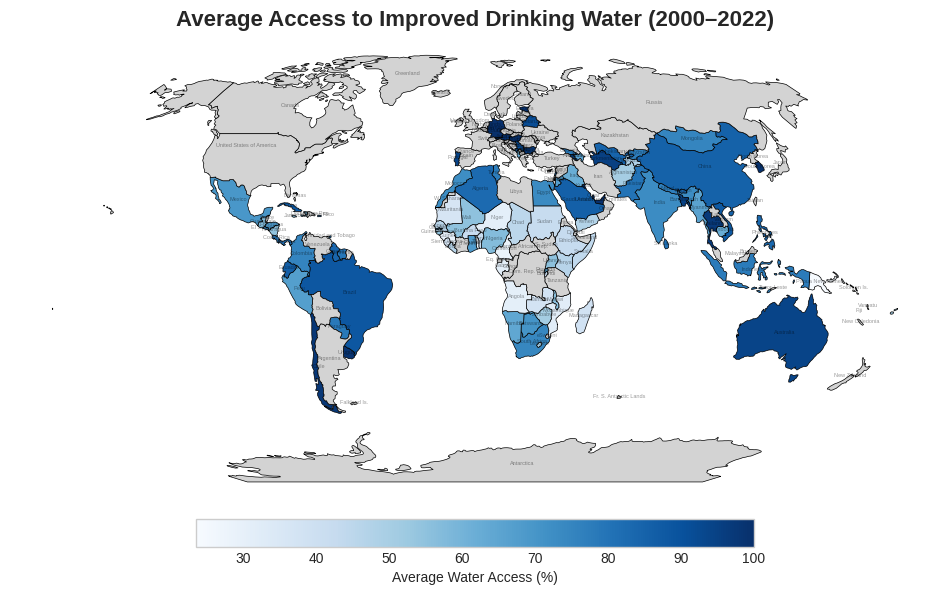

In [208]:
#| echo: true

#Average water access per country (2000–2022)
avg_access = (
    indicator_df_clean
    .filter((pl.col('Year') >= 2000) & (pl.col('Year') <= 2022))
    .group_by('Country')  # <-- corrected
    .agg(pl.col('Water_Access_Percent').mean().alias('Avg_Water_Access')))

#Load World Map Shape File
world = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/WATER_REPORT/natural shape/ne_110m_admin_0_countries.shp")


#Rename columns to match for merge
world = world.rename(columns={"ADM0_A3": "iso_alpha_3", "NAME": "Country"})

# Merge shapefile with water access data
merged = world.merge(avg_access.to_pandas(), on="Country", how="left")

# Reproject for globe shape
merged = merged.to_crs("+proj=robin")  # Robinson projection

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

merged.plot(
    column='Avg_Water_Access',
    cmap='Blues',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': "Average Water Access (%)",
        'orientation': "horizontal",
        'shrink': 0.6,
        'pad': 0.02
    },
    missing_kwds={
        "color": "lightgrey",
        "label": "No data available"
    },
    ax=ax
)

# Add country names faintly
for idx, row in merged.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    plt.annotate(
        text=row['Country'],
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        fontsize=4,
        color='black',
        alpha=0.4,
        ha='center'
    )

# Style the plot
ax.set_title("Average Access to Improved Drinking Water (2000–2022)", fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', color='lightgrey', linewidth=0.5)  # Gridlines neatly
ax.set_axis_off()  # No ugly x/y axis

# Show final beautiful plot
plt.show()

## Global Progress in Clean Drinking Water Access (2000–2022)

This line chart illustrates the global average percentage of the population with access to clean drinking water from the year 2000 through 2022. Each data point represents the average access level for that year, with precise values labelled above the dots for clarity.

While the overall trend is positive, significant disparities remain across regions, emphasizing the need for continued investment and focused efforts to ensure clean water for everyone.



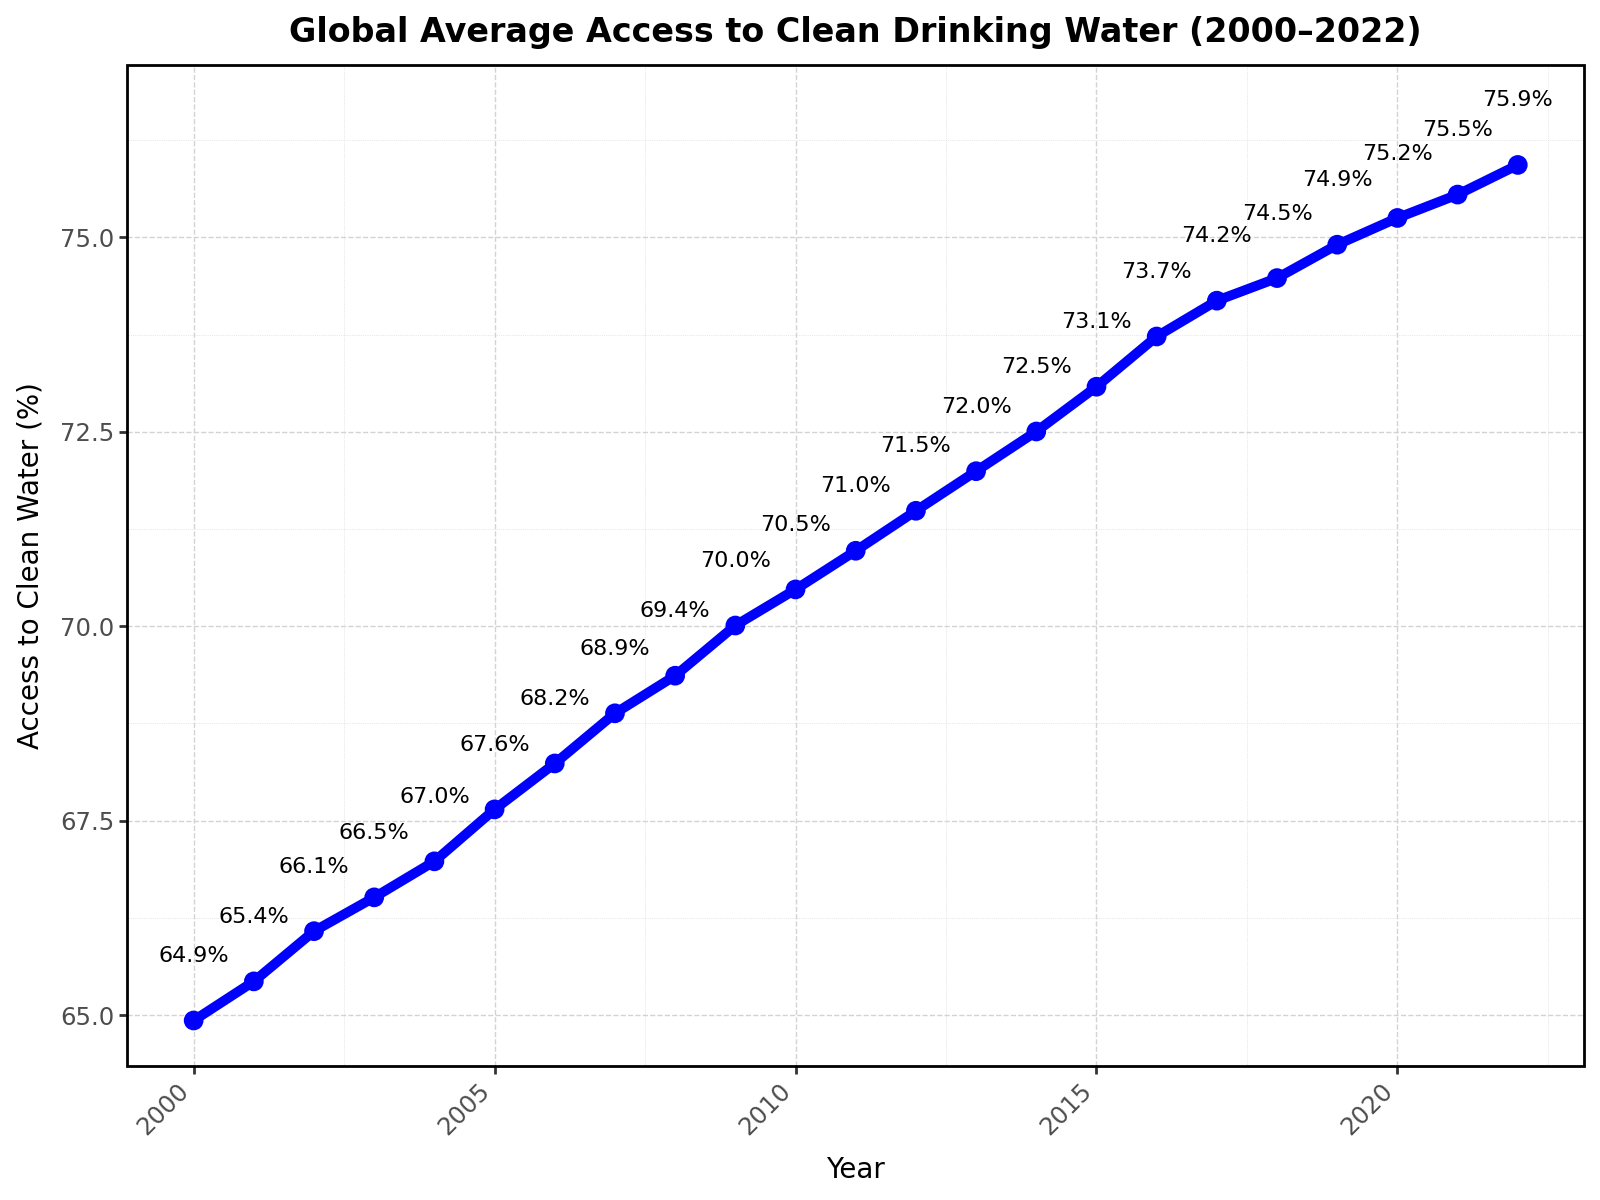

In [209]:
#| echo: true



# Data preparation
global_avg = (
    indicator_df_clean
    .group_by('Year')
    .agg(pl.col('Water_Access_Percent').mean().alias('Avg_Water_Access'))
    .sort('Year')
    .to_pandas()
)

# Plot with
(
    ggplot(global_avg, aes(x='Year', y='Avg_Water_Access'))
    + geom_line(color="blue", size=2)
    + geom_point(color="blue", size=3)

    # Add labels
    + geom_text(
        aes(label=global_avg['Avg_Water_Access'].round(1).astype(str) + '%'),
        color='black',
        size=8,
        nudge_y=0.7,
        va='bottom'  # vertical alignment
    )

    # Titles and axis labels
    + labs(
        title='Global Average Access to Clean Drinking Water (2000–2022)',
        x='Year',
        y='Access to Clean Water (%)'
    )

    # Theme
    + theme(
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color='black', fill=None, size=1),
        panel_grid_major=element_line(color='lightgrey', size=0.5, linetype='--'),
        panel_grid_minor=element_line(color='lightgrey', size=0.25, linetype=':'),
        axis_text_x=element_text(rotation=45, ha='right'),
        plot_title=element_text(size=12, weight='bold'),
        axis_title=element_text(size=10),
        figure_size=(8, 6)
    )
)


## Global Access Levels to Clean Drinking Water (2022)

The donut chart below categorizes countries based on their population's access to clean drinking water in 2022.  
It highlights that while a significant number of countries have achieved near-universal access (95%–100%), many still remain within lower access brackets, underscoring the global disparities in access to safe drinking water.



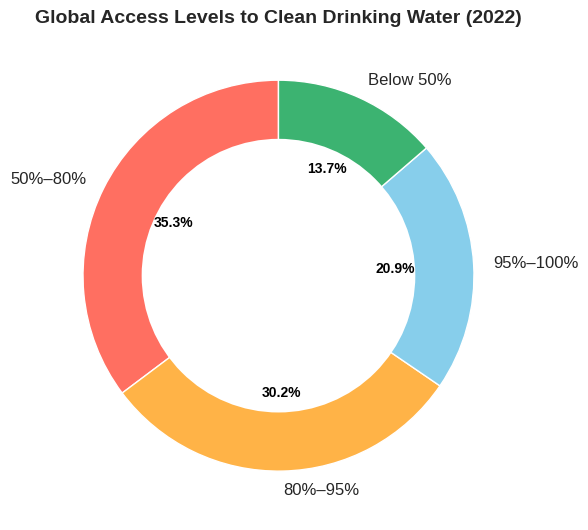

In [210]:
#Prepare water access categories
water_2022 = (
    indicator_df_clean
    .filter(pl.col('Year') == 2022)
    .select(['Country', 'Water_Access_Percent'])
    .drop_nulls(subset=['Water_Access_Percent'])
)

#Categorizing
water_2022 = water_2022.with_columns(
    pl.when(pl.col('Water_Access_Percent') < 50)
      .then(pl.lit('Below 50%'))
    .when(pl.col('Water_Access_Percent') < 80)
      .then(pl.lit('50%–80%'))
    .when(pl.col('Water_Access_Percent') < 95)
      .then(pl.lit('80%–95%'))
    .otherwise(pl.lit('95%–100%'))
    .alias('Access_Category')
)

#Group by category
access_counts = (
    water_2022
    .group_by('Access_Category')
    .agg(pl.len().alias('Country_Count'))
    .sort('Access_Category')
    .to_pandas()
)



# Colors matching your previous theme
colors = ['#FF6F61', '#FFB347', '#87CEEB', '#3CB371']

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot donut
wedges, texts, autotexts = ax.pie(
    access_counts['Country_Count'],
    labels=access_counts['Access_Category'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')  # THIS makes it a donut (white center)
)

#text
plt.setp(autotexts, size=10, weight="bold", color='black')
plt.setp(texts, size=12)

# Title and Background
ax.set_title('Global Access Levels to Clean Drinking Water (2022)', fontsize=14, weight='bold')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Center circle (white) to make real donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)


# Display
plt.tight_layout()
plt.show()


## Progress in Clean Water Access: 2000 vs 2022 (Vertical Comparison)

The vertical bar chart below compares water access percentages in 2000 and 2022 for the top 10 countries with the greatest improvements.  
The distinct color coding and value labels highlight the impressive progress made in clean water infrastructure across these nations over the past two decades.


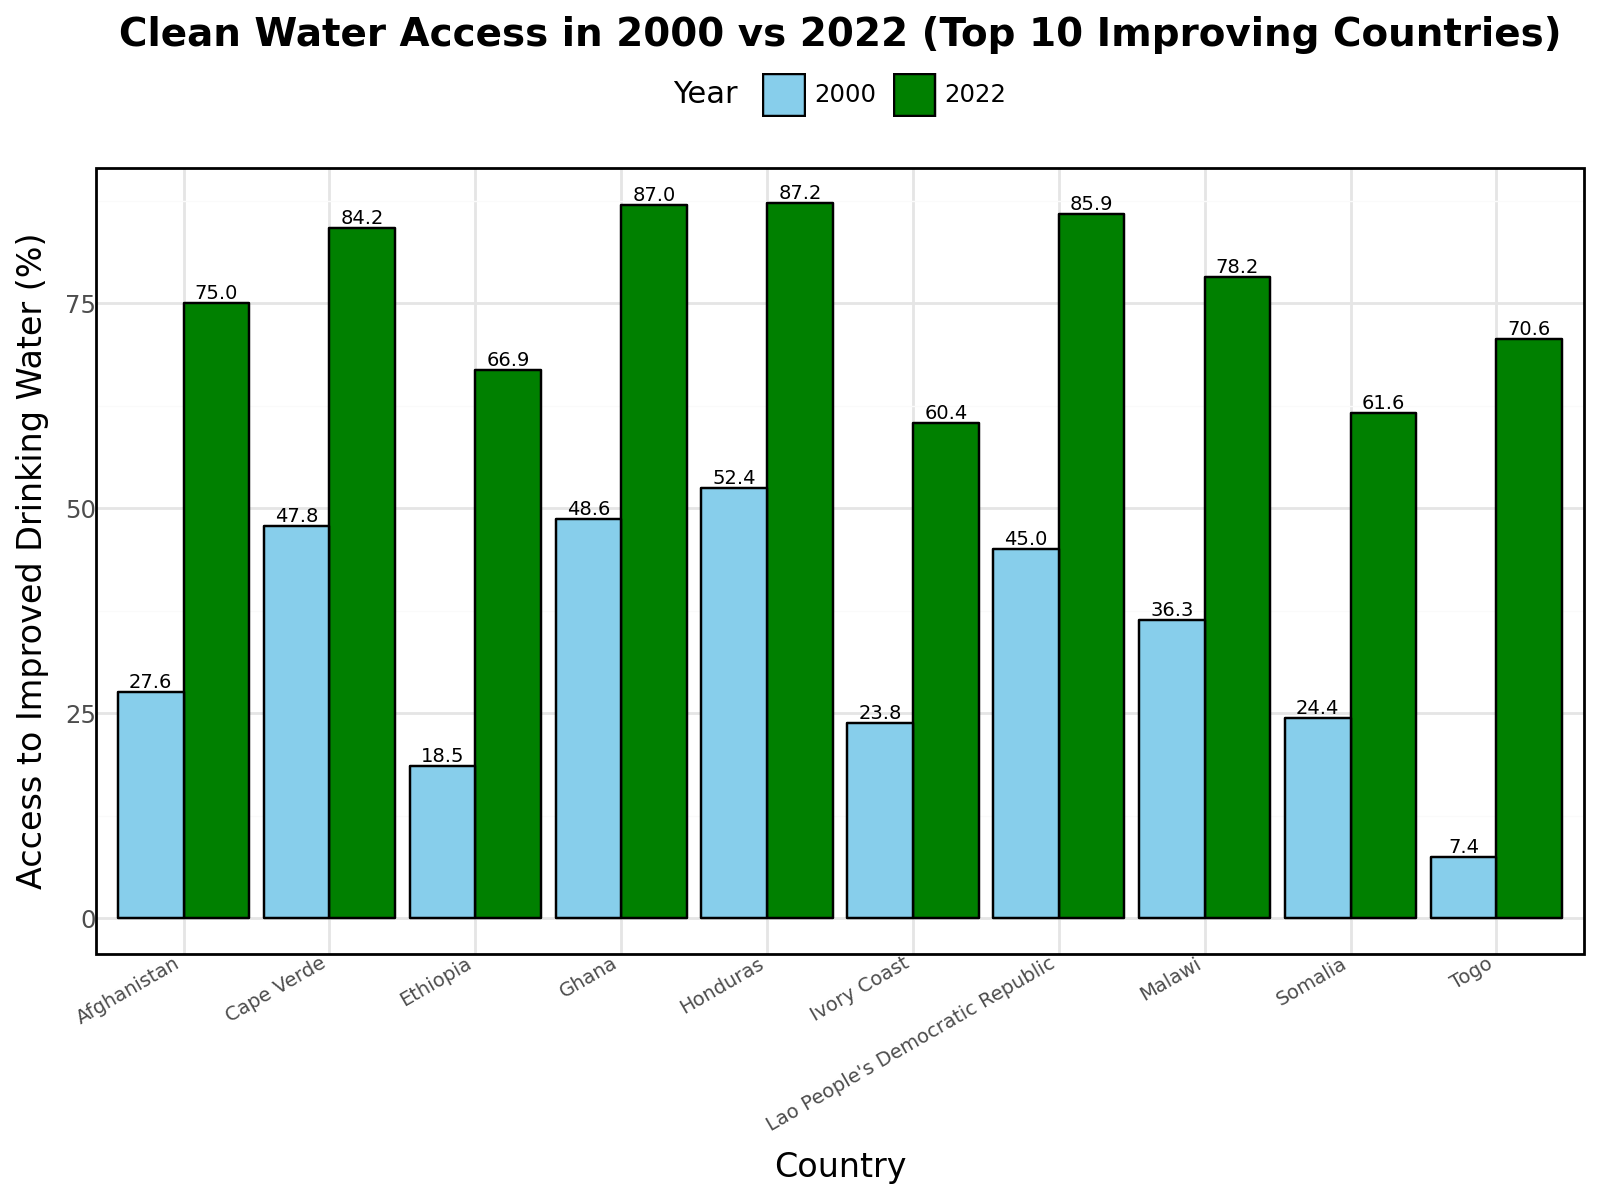

In [211]:
#Filter and merge 2000 and 2022 using Pandas
df_2000 = indicator_df_clean.to_pandas()
df_2000 = df_2000[df_2000['Year'] == 2000][['Country', 'Water_Access_Percent']]
df_2000 = df_2000.rename(columns={'Water_Access_Percent': 'Access_2000'})

df_2022 = indicator_df_clean.to_pandas()
df_2022 = df_2022[df_2022['Year'] == 2022][['Country', 'Water_Access_Percent']]
df_2022 = df_2022.rename(columns={'Water_Access_Percent': 'Access_2022'})

#Merge and Improvement Calculation
df_compare = pd.merge(df_2000, df_2022, on='Country')
df_compare['Improvement'] = df_compare['Access_2022'] - df_compare['Access_2000']

#Select Top 10 Improving Countries
top10_compare = df_compare.sort_values(by='Improvement', ascending=False).head(10)

#Side-by-side plotting
top10_melt = top10_compare.melt(id_vars='Country', value_vars=['Access_2000', 'Access_2022'],
                                var_name='Year', value_name='Access_Percent')
top10_melt['Year'] = top10_melt['Year'].replace({'Access_2000': '2000', 'Access_2022': '2022'})


custom_colors = ["SkyBlue", "Green"]

compare_vertical_plot = (
    ggplot(top10_melt, aes(x='Country', y='Access_Percent', fill='Year')) +
    geom_col(position='dodge', color='black') +
    geom_text(
        aes(label='round(Access_Percent, 1)'),
        position=position_dodge(width=0.9),
        va='bottom', size=7, format_string='{:.1f}'
    ) +
    scale_fill_manual(values=custom_colors) +
    labs(
        title="Clean Water Access in 2000 vs 2022 (Top 10 Improving Countries)",
        x="Country",
        y="Access to Improved Drinking Water (%)",
        fill="Year"
    ) +
    theme_minimal() +
    theme(
        figure_size=(8, 6),
        axis_text_x=element_text(angle=30, hjust=1, size=7),
        plot_title=element_text(weight='bold', size=14),
        axis_title_y=element_text(size=12),
        axis_title_x=element_text(size=12),
        legend_position='top',
        panel_border=element_rect(color='black', fill=None)
    )
)

#Display

display(compare_vertical_plot)


## Bottom 10 Countries: Water Access Comparison (2000 vs 2022)

The bar chart below compares clean drinking water access levels in 2000 and 2022 for the countries with the lowest access rates. While some progress is visible, significant gaps remain, underscoring the urgent need for accelerated water infrastructure and humanitarian support in these regions.



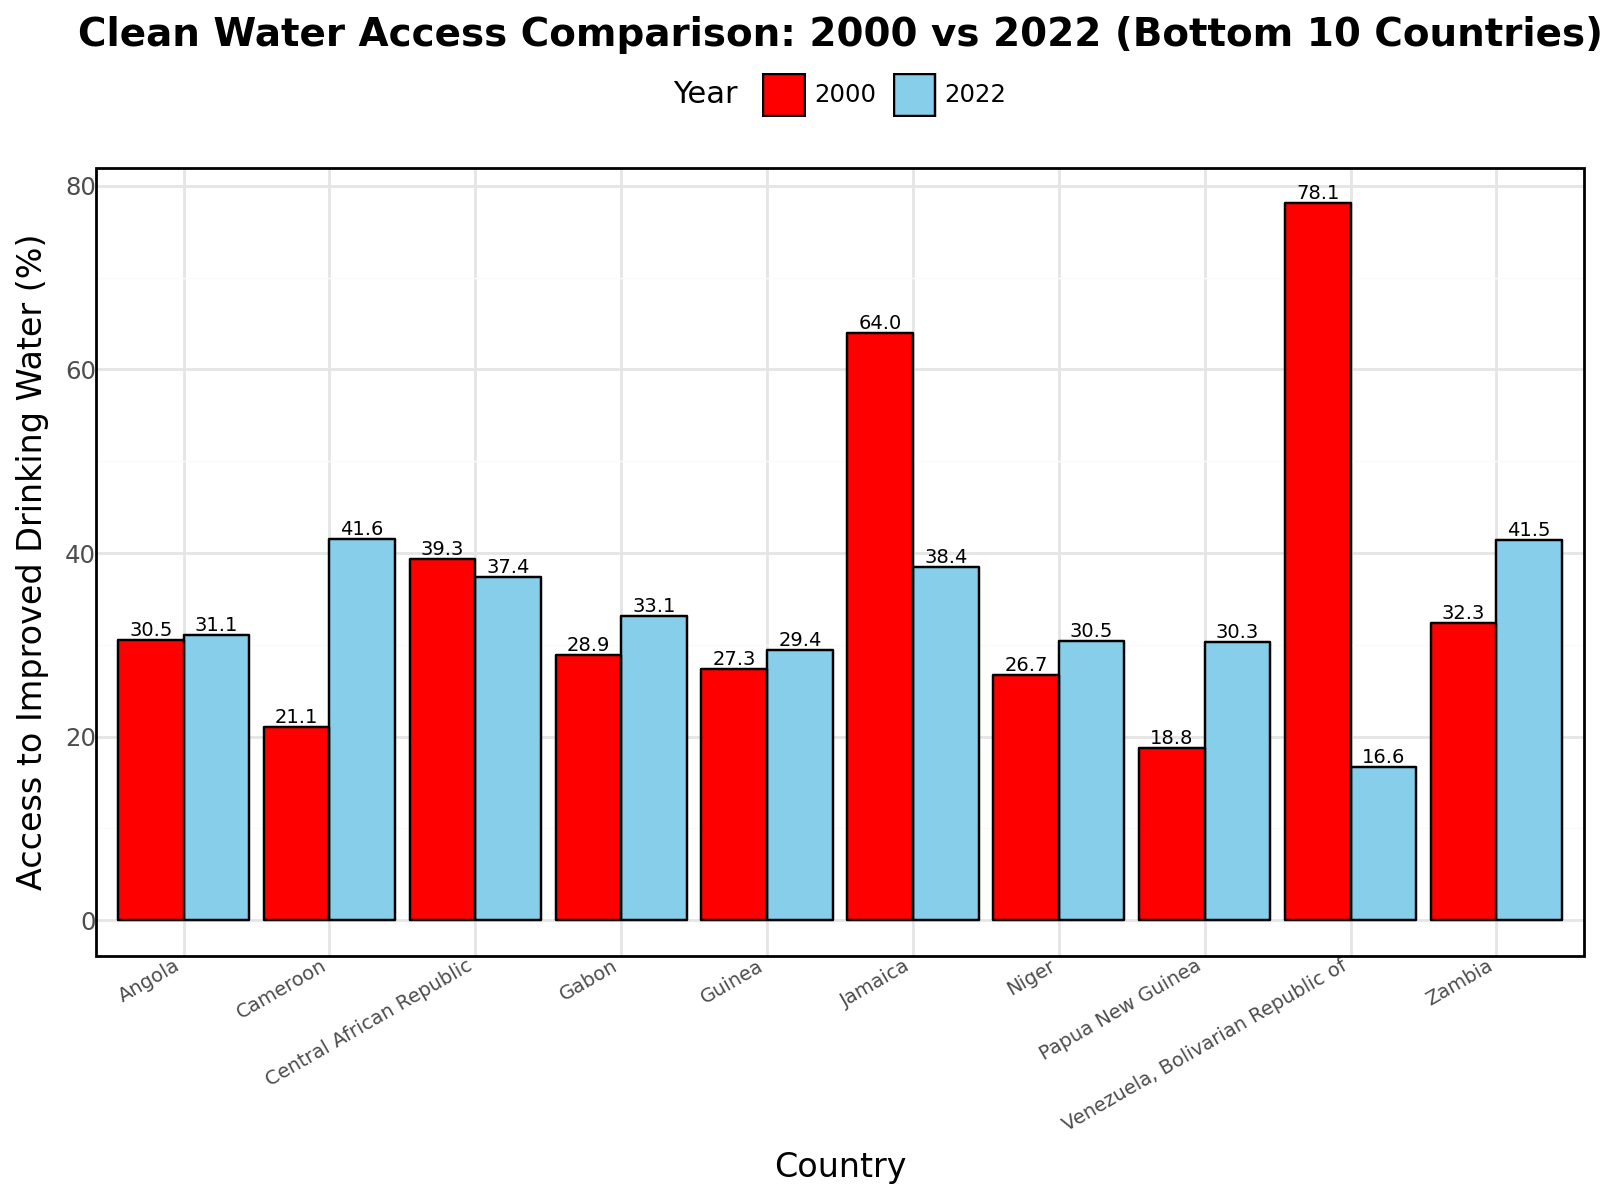

In [212]:
#Filter data for 2000 and 2022
df_2000_bottom = (
    indicator_df_clean.to_pandas()
    .query('Year == 2000')
    [['Country', 'Water_Access_Percent']]
    .rename(columns={'Water_Access_Percent': 'Access_2000'})
)

df_2022_bottom = (
    indicator_df_clean.to_pandas()
    .query('Year == 2022')
    [['Country', 'Water_Access_Percent']]
    .rename(columns={'Water_Access_Percent': 'Access_2022'})
)

#Merge and Improvement Calculation
df_compare_bottom = pd.merge(df_2000_bottom, df_2022_bottom, on='Country')
df_compare_bottom['Improvement'] = df_compare_bottom['Access_2022'] - df_compare_bottom['Access_2000']

#Select Bottom 10 based on 2022 Access
bottom10_compare = df_compare_bottom.sort_values(by='Access_2022', ascending=True).head(10)

#plotting
bottom10_melt = bottom10_compare.melt(
    id_vars='Country',
    value_vars=['Access_2000', 'Access_2022'],
    var_name='Year',
    value_name='Access_Percent'
)

#Clean Year Names
bottom10_melt['Year'] = bottom10_melt['Year'].replace({'Access_2000': '2000', 'Access_2022': '2022'})

#Plot using plotnine


bottom10_compare_plot = (
    ggplot(bottom10_melt, aes(x='Country', y='Access_Percent', fill='Year')) +
    geom_col(position='dodge', color='black') +
    geom_text(
        aes(label='round(Access_Percent, 1)'),
        position=position_dodge(width=0.9),
        va='bottom',
        size=7,
        format_string='{:.1f}'
    ) +
    scale_fill_manual(values=["Red", "SkyBlue"]) +
    labs(
        title="Clean Water Access Comparison: 2000 vs 2022 (Bottom 10 Countries)",
        x="Country",
        y="Access to Improved Drinking Water (%)",
        fill="Year"
    ) +
    theme_minimal() +
    theme(
        figure_size=(12, 6),
        axis_text_x=element_text(angle=30, hjust=1, size=7),
        plot_title=element_text(weight='bold', size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        legend_position='top',
        panel_border=element_rect(color='black', fill=None)
    )
)


#Filter data for 2000 and 2022
df_2000_bottom = (
    indicator_df_clean.to_pandas()
    .query('Year == 2000')
    [['Country', 'Water_Access_Percent']]
    .rename(columns={'Water_Access_Percent': 'Access_2000'})
)

df_2022_bottom = (
    indicator_df_clean.to_pandas()
    .query('Year == 2022')
    [['Country', 'Water_Access_Percent']]
    .rename(columns={'Water_Access_Percent': 'Access_2022'})
)

#Merge and Improvement Calculation
df_compare_bottom = pd.merge(df_2000_bottom, df_2022_bottom, on='Country')
df_compare_bottom['Improvement'] = df_compare_bottom['Access_2022'] - df_compare_bottom['Access_2000']

#Select Bottom 10 based on 2022 Access
bottom10_compare = df_compare_bottom.sort_values(by='Access_2022', ascending=True).head(10)

#plotting
bottom10_melt = bottom10_compare.melt(
    id_vars='Country',
    value_vars=['Access_2000', 'Access_2022'],
    var_name='Year',
    value_name='Access_Percent'
)

#Clean Year Names
bottom10_melt['Year'] = bottom10_melt['Year'].replace({'Access_2000': '2000', 'Access_2022': '2022'})

#Plot


bottom10_compare_plot = (
    ggplot(bottom10_melt, aes(x='Country', y='Access_Percent', fill='Year')) +
    geom_col(position='dodge', color='black') +
    geom_text(
        aes(label='round(Access_Percent, 1)'),
        position=position_dodge(width=0.9),
        va='bottom',
        size=7,
        format_string='{:.1f}'
    ) +
    scale_fill_manual(values=["Red", "SkyBlue"]) +
    labs(
        title="Clean Water Access Comparison: 2000 vs 2022 (Bottom 10 Countries)",
        x="Country",
        y="Access to Improved Drinking Water (%)",
        fill="Year"
    ) +
    theme_minimal() +
    theme(
        figure_size=(8, 6),
        axis_text_x=element_text(angle=30, hjust=1, size=7),
        plot_title=element_text(weight='bold', size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        legend_position='top',
        panel_border=element_rect(color='black', fill=None)
    )
)

#Display

display(bottom10_compare_plot)





## Relationship between Clean Water Access and GDP per Capita (2022)

The scatter plot below reveals a positive correlation between GDP per capita and access to improved drinking water sources.  
The regression line (trendline) indicates that countries with higher economic prosperity generally experience higher rates of clean water access, showing the critical link between financial the the critical link between economic development and public health infrastructure.



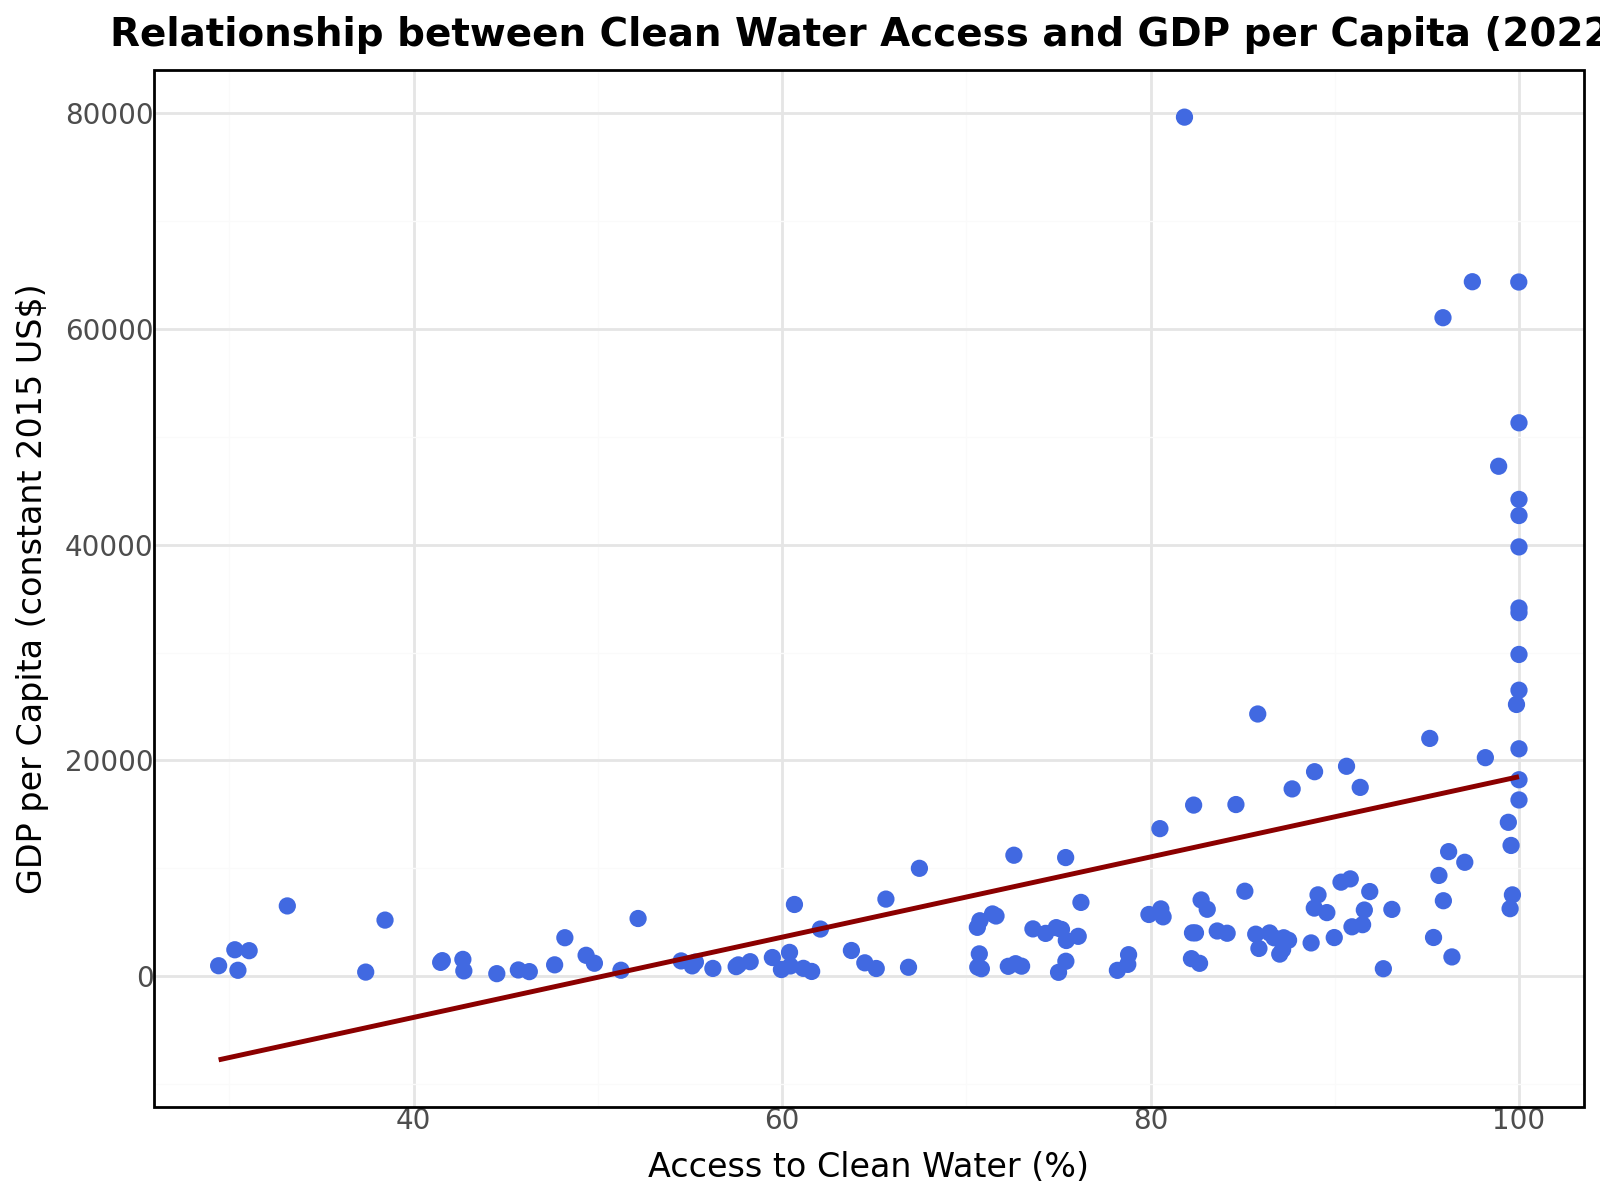

In [213]:
#Prepare water access and GDP per capita for 2022
water_2022 = (
    indicator_df_clean.to_pandas()
    .query('Year == 2022')
    [['Country', 'Water_Access_Percent']]
)

gdp_2022 = (
    metadata_df.to_pandas()
    .query('year == 2022')
    [['country', 'GDP per capita (constant 2015 US$)']]
)

#Merge datasets
scatter_df = pd.merge(
    water_2022,
    gdp_2022,
    left_on='Country',
    right_on='country',
    how='inner'
)

#Clean column names
scatter_df = scatter_df.rename(columns={'GDP per capita (constant 2015 US$)': 'GDP_Per_Capita'})
scatter_df = scatter_df.drop(columns=['country'])

#Drop missing values
scatter_df = scatter_df.dropna(subset=['Water_Access_Percent', 'GDP_Per_Capita'])

#Plot using plotnine

scatter_plot = (
    ggplot(scatter_df, aes(x='Water_Access_Percent', y='GDP_Per_Capita')) +
    geom_point(color='royalblue', size=2.5) +
    geom_smooth(method='lm', color='darkred', se=False) +
    labs(
        title="Relationship between Clean Water Access and GDP per Capita (2022)",
        x="Access to Clean Water (%)",
        y="GDP per Capita (constant 2015 US$)"
    ) +
    theme_minimal() +
    theme(
        figure_size=(8, 6),
        plot_title=element_text(weight='bold', size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        panel_border=element_rect(color='black', fill=None),
        axis_text=element_text(size=10)
    )
)

#Display the chart
display(scatter_plot)



## Impact of Clean Water Access on Life Expectancy (2022)

The scatter plot below illustrates the positive relationship between access to clean drinking water and life expectancy across countries in 2022.  
The regression line demonstrates that nations with higher rates of clean water access tend to enjoy longer life expectancies, highlighting the essential role of basic services in promoting public health and longevity.




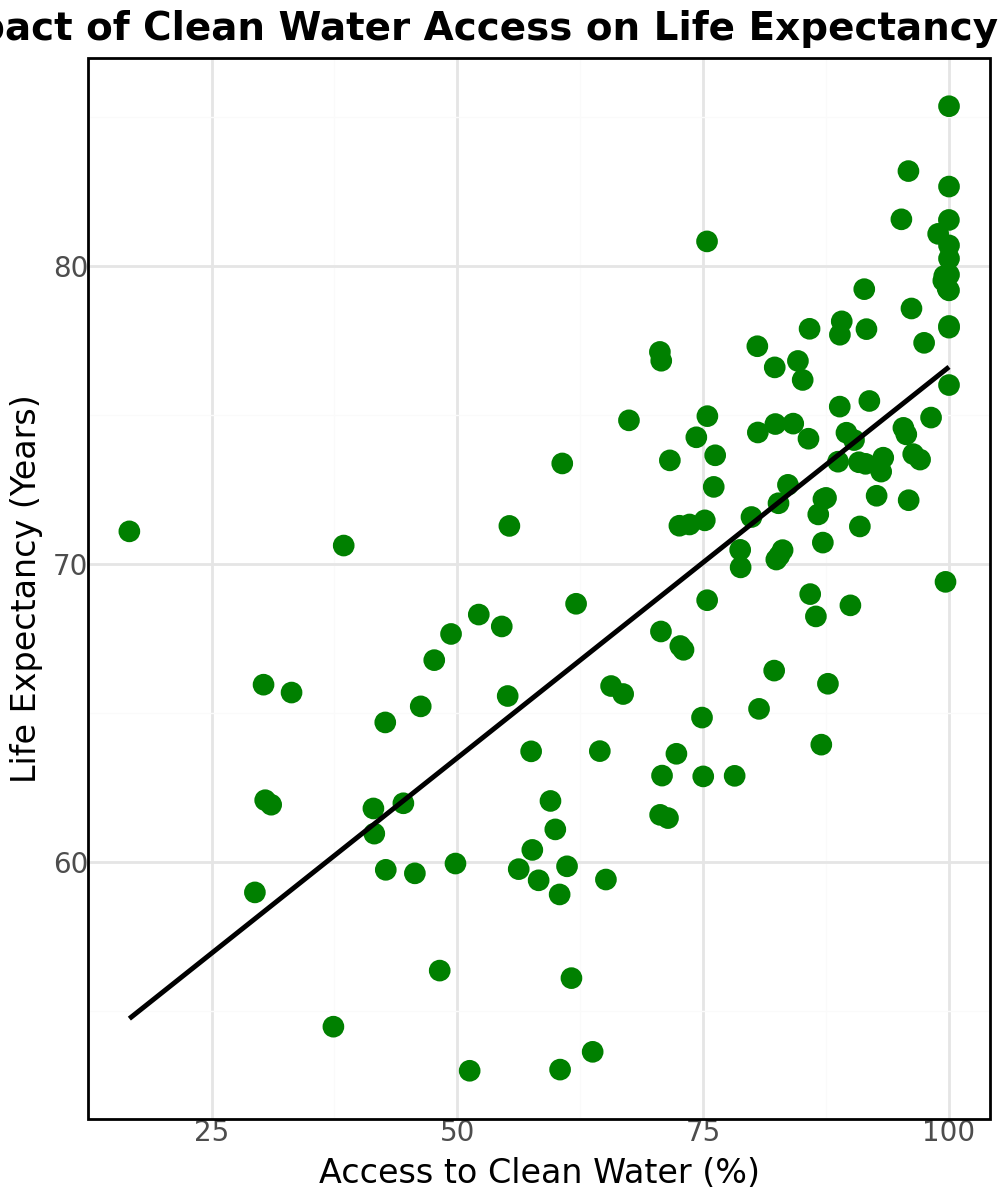

In [214]:
#Prepare water access data for 2022
water_2022 = (
    indicator_df_clean.to_pandas()
    .query('Year == 2022')
    [['Country', 'Water_Access_Percent']]
    .dropna(subset=['Water_Access_Percent'])
)

#life expectancy data for 2022
life_2022 = (
    metadata_df.to_pandas()
    .query('year == 2022')
    [['country', 'Life expectancy at birth, total (years)']]
    .dropna()
)

#Merge datasets
life_water_df = pd.merge(
    water_2022,
    life_2022,
    left_on='Country',
    right_on='country',
    how='inner'
)

#Clean columns
life_water_df = life_water_df.rename(columns={'Life expectancy at birth, total (years)': 'Life_Expectancy'})
life_water_df = life_water_df.drop(columns=['country'])

#plot

life_expectancy_plot = (
    ggplot(life_water_df, aes(x='Water_Access_Percent', y='Life_Expectancy')) +
    geom_point(color='green', size=3, stroke=0.7, shape='o') +
    geom_smooth(method='lm', color='black', se=False) +
    labs(
        title="Impact of Clean Water Access on Life Expectancy (2022)",
        x="Access to Clean Water (%)",
        y="Life Expectancy (Years)"
    ) +
    theme_minimal() +
    theme(
        figure_size=(5, 6),
        plot_title=element_text(weight='bold', size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        panel_border=element_rect(color='black', fill=None),
        axis_text=element_text(size=10)
    )
)

#Display
display(life_expectancy_plot)


# **Conclusion and Recommendations**

Over the past two decades, the world has made important strides in improving access to clean drinking water.  
Many regions have seen remarkable progress, reflecting the global commitment to public health and sustainable development.  
However, the journey is far from over. Today, millions of people — especially in Sub-Saharan Africa and parts of Asia — still live without reliable access to safe water.

Our analysis shows a clear link: countries with better clean water access tend to enjoy higher life expectancy and stronger economies.  
This highlights why access to water isn't just about survival, it is about opportunity, dignity, and a better life.

But progress is uneven. Without greater investment and stronger partnerships, the gap between those who have clean water and those who do not will only widen.

We recommend:

- Prioritizing investment in sustainable, resilient water infrastructure
- Targeting the most vulnerable regions first
- Supporting innovative, community-led solutions
- Building stronger international partnerships to drive action

Access to clean water is a human right — not a privilege.  
It is essential to health, education, gender equality, and economic development.


## Take Action 🔔

Access to clean water changes everything,
it saves lives, supports education, and builds stronger communities.

You can help make a difference.

Join UNICEF’s global effort to ensure every child has the right to safe drinking water:  
👉 [**Donate to UNICEF Today**](https://www.unicef.org.uk/donate/)
